In [1]:
import numpy as np
import pandas as pd
import gc

file_path = '../data/transactions.csv'

data_raw = pd.read_csv(file_path)
data_full = data_raw.copy()

last_wrong_block = 24040841

correct_mask = (
    (data_full.block_num > last_wrong_block) & 
    (data_full.caller != data_full.sender) & 
    (~data_full.caller.isna()) & 
    (~data_full.sender.isna()) & 
    (~data_full.input_token_symbol.isna()) & 
    (~data_full.output_token_symbol.isna()) & 
    (~data_full.input_value.isna()) & 
    (~data_full.output_value.isna())
)
data_full = data_full[correct_mask]
data_full['datetime'] = pd.to_datetime(data_full['datetime'])

useful_columns = [
    'timestamp',
    'datetime',
    'caller',
    'sender',
    'input_token_symbol',
    'output_token_symbol',
    'input_value',
    'output_value'
]
useful_data = data_full[useful_columns]
gc.collect()
useful_data.shape

(1453946, 8)

In [2]:
all_tokens = pd.concat([useful_data['input_token_symbol'], useful_data['output_token_symbol']]).value_counts()
all_tokens

WETH         907562
USDC         323232
USDT         315514
ETH          140493
WBTC          84156
              ...  
X-GPT             1
OPTIMOUSE         1
€                 1
PAIRED            1
PUBO              1
Name: count, Length: 8907, dtype: int64

In [78]:
def get_data_by_2_coins(data, small_coin, big_coin):
    data = data.copy()
    data = data[data.input_token_symbol.isin([small_coin, big_coin]) & data.output_token_symbol.isin([small_coin, big_coin])]
    ok_mask = data.input_token_symbol == big_coin
    def swap(lst, str1, str2):
        ind1, ind2 = lst.index(str1), lst.index(str2)
        lst = lst[:]
        lst[ind1], lst[ind2] = lst[ind2], lst[ind1]
        return lst
        
    columns = list(data.columns)
    columns = swap(columns, 'caller', 'sender')
    columns = swap(columns, 'input_token_symbol', 'output_token_symbol')
    columns = swap(columns, 'input_value', 'output_value')
    
    data[~ok_mask] = data[~ok_mask].reindex(columns=columns)
    return data

data = get_data_by_2_coins(useful_data, 'USDT', 'WETH')
data['price'] = data.output_value / data.input_value

price_std = data.price.std()
price_mean = data.price.mean()
outlier_mask = np.abs(data.price - price_mean) > 3 * price_std

data = data[~outlier_mask]

In [90]:
from sklearn.preprocessing import StandardScaler

def get_time_embed(data):
    n = data.shape[0]
    all_users = pd.concat([data['caller'], data['sender']]).value_counts()
    often_users_mask = all_users >= n // 100
    often_users = set(all_users[often_users_mask].index)
    rare_users = set(all_users[~often_users_mask].index)

    def type_by_row(row):
        ctype = row.caller in often_users
        stype = row.sender in often_users

        if ctype and stype:
            return 'often'
        if not ctype and not stype:
            return 'rare'
        return 'transfer'

    freq = '30min'
    data['tx_type'] = data.apply(type_by_row, axis=1)
    data['rounded_time'] = data.datetime.dt.round(freq)
    out = data.groupby(by=['rounded_time', 'tx_type']).agg({'output_value': 'sum', 'price': 'mean'}).unstack("tx_type")

    out.columns = [
        f"{metric}_{tx_type}"
        for metric, tx_type in out.columns
    ]
    out.index.freq = freq
    return out


Xt = get_time_embed(data)
n = int(Xt.shape[0] * 0.8)

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(Xt.iloc[:n, :])
X_test = std_scaler.transform(Xt.iloc[n:, :])

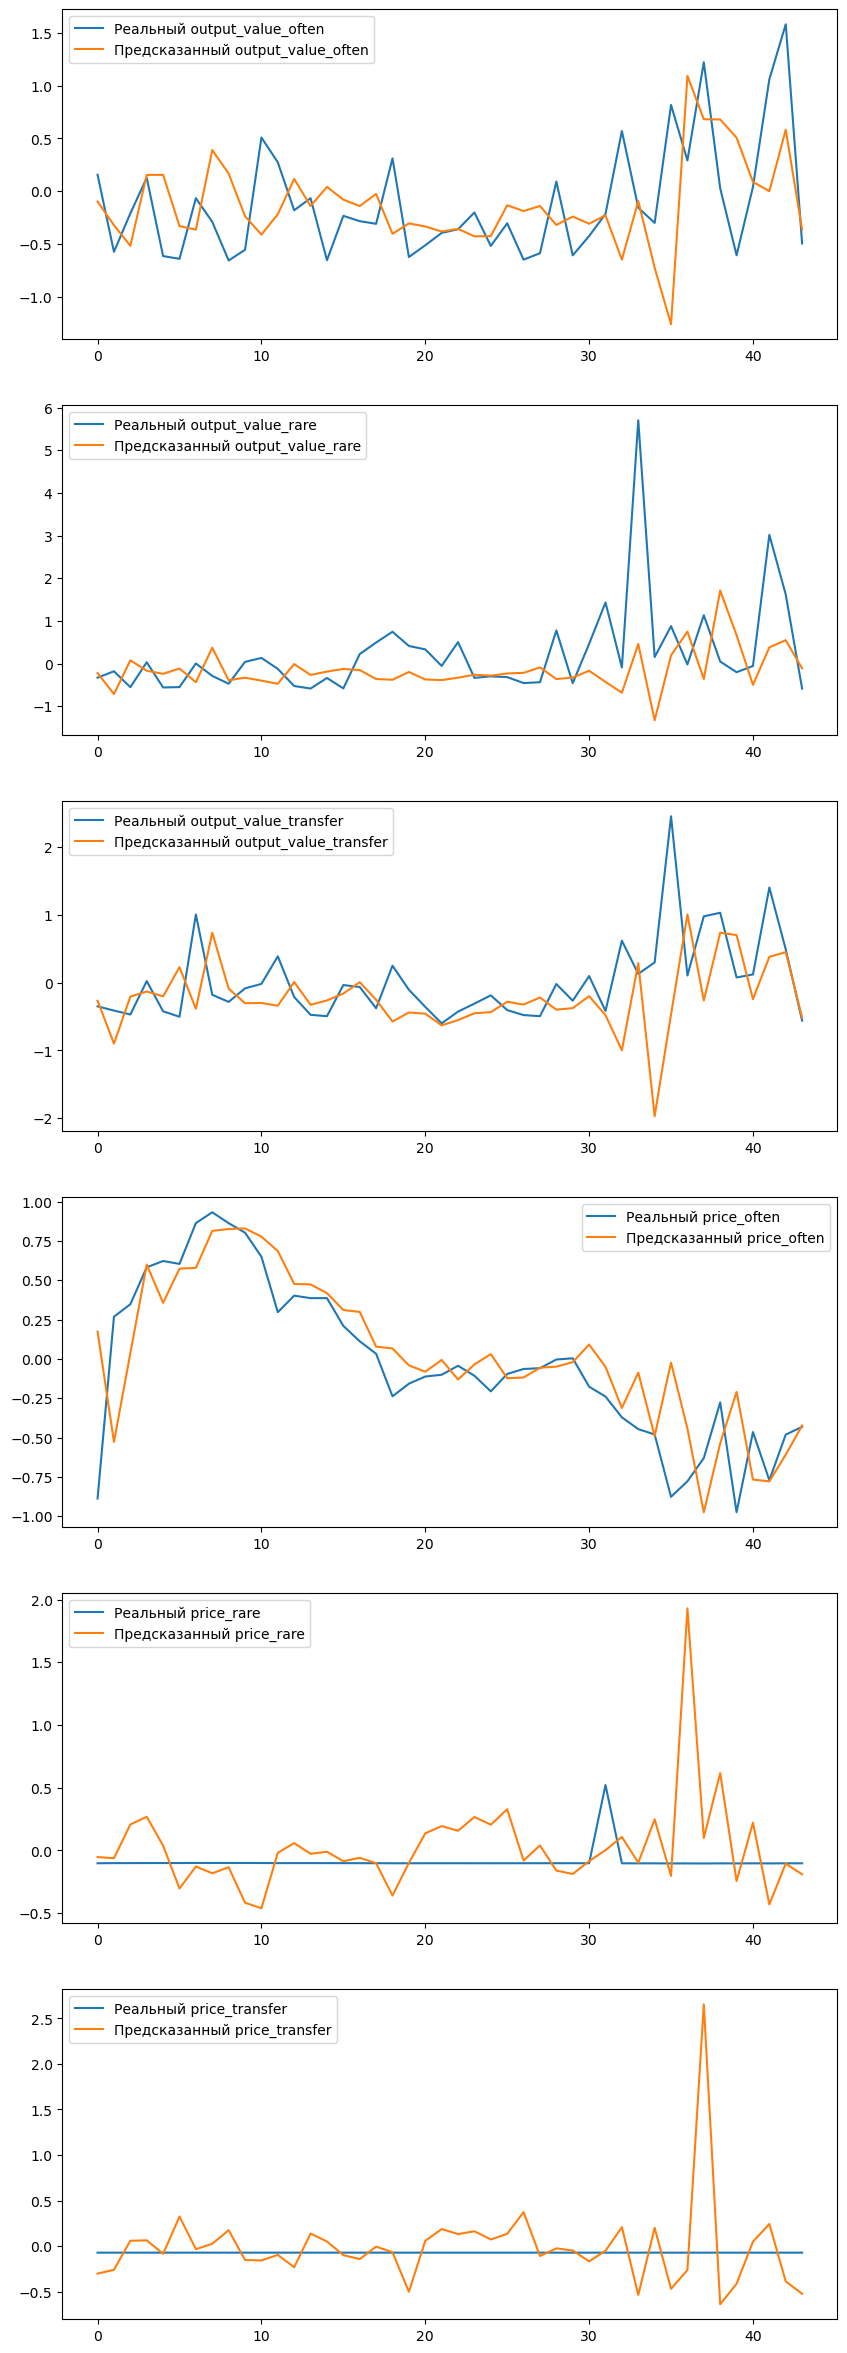

In [94]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

model_fitted = VAR(X_train).fit(5)
lag_order = model_fitted.k_ar

predictions = []

for i in range(lag_order, len(X_test)):
    input_data = X_test[i - lag_order: i, :]
    
    yhat = model_fitted.forecast(y=input_data, steps=1)
    
    predictions.append(yhat[0])

df_forecast_one_step = pd.DataFrame(predictions, index=Xt.index[n + lag_order:], columns=Xt.columns)

fig, axs = plt.subplots(Xt.shape[1], figsize=(10, 5 * Xt.shape[1]))

assert(X_test[lag_order:, :].shape == df_forecast_one_step.shape)
for i, ax in enumerate(axs):
    ax.plot(X_test[lag_order:, i], label=f'Реальный {Xt.columns[i]}')
    ax.plot(df_forecast_one_step.to_numpy()[:, i], label=f'Предсказанный {Xt.columns[i]}')
    ax.legend()